# Explainer Notebook
#### Social graphs and interactions 02805
#### Technical University of Denmark

In [1]:
# This cell is included to show what libraries are imported and used in the project
import matplotlib.pyplot as plt
import numpy as np
import random
import networkx as nx
import json
import re
import urllib2
import nltk
from nltk.corpus import stopwords
import string
import math
from wordcloud import WordCloud
import community
%matplotlib inline

## Part 1: Motivation

This project will examine proporties of a Network based on the stars on the Hollywood Walk of Fame. The central idea behind the project is to look for any person that stands out as a central part of this network, one person we could more memorable and prominent. This spawned some of the other ideas behind the project, once the network is created we can look for communities, see if anything corresponds with the real world. Information about the stars on the Hollywood Walk of Fame can be found on Wikipedia and since we have already worked with data from Wikipedia in the course it was natural to select it as the data set. The dataset will therefore be the Wikipedia pages of all stars mentioned on this [list](https://en.wikipedia.org/wiki/List_of_stars_on_the_Hollywood_Walk_of_Fame). The editing wikipages will in url format and the pages represented as normal text will also be saved, this the dataset comprises wikipages of all the persons that have a star on the Hollywood Walk of Fame in two formats.

The ideas for project analysis came after the choice of dataset. I wanted to work with something movie or franchise related so I looked for this also keeping in mind that I didn't want something everybody would choose. Game of Thrones and Star Wars was the first ideas but were thrown away because of the popularity of the topics. While deciding on a dataset it was important that would be relatively easy to create a sensible network, so for every dataset idea I looked for list on he webpages of say characters in the Lord of the Rings universe. This ultimately let me to the list of persons on the Hollywood Walk of Fame and thought it would be fun to find a central star. This data also calls for logical communities (actors with actors, singers with singers, etc.) and since it is Wikipedia, there is plenty of text for analysis.

As mentioned it could fun to detect some groups in the network that corresponds with what we now from the real world. Is it possible to find any proposed communities like groups of actors or award winning persons. The wikipages' texts will also be analyzed in the project. The text analysis would mainly be about creating TF-IDF vectors to find keywords for the Hollywood network, can any words explain Hollywood stardom. The TF-IDF vetor approach can also be applied to the communities to explain what lies behind them. If any user would like to know which star you shouldn't forget to photograhp on the Hollywood Walk of Fame, this project finds the most outstanding star (network wise). These are the important goals for end users in this project.

## Part 2: Basic statistics

This section will explain how the data was downloaded, cleaned and preprocessed and give some basic statistics of the created Hollywood star network.

### Download data and construct network
First up is how the dataset is downloaded. This is done using Wikipedia's API. It is a straight forward for downloading information from wikipages plus we have used it before in the course. First the url is fetched using the constructed query of the wikipage. Once we have the wikipage we extract the information we need as page links which have a specific expression in url wikipage. We extract links with a regular expression. Because we are only interested in names on stars, there any real problems with unicode. Next up is removing unwanted matches from the regex. Luckily the wikipage with the list of Hollywood stars is ordered in a simple way and does not contain many unneeded links. The first and last couple of mathes found using the regex is not links to persons with stars in the Walk of Famel, so we remove these. Exactly how many to remove is determined by looking at list of matches. The nodes in the network still to be created is gonna the names of star recipients. Some matches/links are made up of two parts, e.g. like this "Bill Boyd (musician)|Bill Boyd". The data needs to cleaned, so no links are two-parted, we just want the first part as it let us distinguish between persons with the same yet and it can then be used to query for the right person's wikipage.

In [2]:
# Construct query of page
baseurl = "https://en.wikipedia.org/w/index.php?"
action = "action=edit"
title = "title=List_of_stars_on_the_Hollywood_Walk_of_Fame"
query = "%s%s&%s" % (baseurl, title, action)

print query

# Fetch file using url. urllib2 is used in python 2.7
response = urllib2.urlopen(query)
wikisource = response.read()

# Use regular expression to get list of stars
# Find all wiki links in the strings from wikisources
brac = re.findall('\[{2}(.+?)\]{2}', wikisource)
stars = brac

# Clean up list of links by removing elements in list that are not stars
stars = stars[3:]
stars = stars[:-7]
# Delete a links to other places in the list, i.e. links to the wikipage containing the list
# Remove vertical lines links
del_idx = []
for idx, star in enumerate(stars):
    if star == "Los Angeles Times":
        del_idx.append(idx)
    match1 = re.search('(.*)\|', star)
    match2 = re.search('(#.+)', star)
    if match1 != None:
        stars[idx] = match1.group(1)
    if match2 != None:
        del_idx.append(idx)
for idx in reversed(del_idx):
    del stars[idx]

https://en.wikipedia.org/w/index.php?title=List_of_stars_on_the_Hollywood_Walk_of_Fame&action=edit


In [3]:
# Print some of the stars on the Hollywood Walk of Fame
for i in range(20):
    idx = random.randint(0, len(stars))
    print stars[idx]

Earl Holliman
Ben Turpin
John Ford
Magic Johnson
Jennifer Lopez
Ken Murray (entertainer)
Ed Harris
Helen Mirren
Claire Danes
Charles Winninger
Carmen Cavallaro
Lily Pons
Mike Gore
Jerome Cowan
Bill Cunningham (talk show host)
Allison Janney
John Charles Thomas
Dennis James
Adolphe Menjou
Jack White (film producer)


In [4]:
# How many stars are there on the Hollywood Walk of Fame?
print "Number of stars/famous people on the Hollywood Walk of Fame: " + str(len(stars))

Number of stars/famous people on the Hollywood Walk of Fame: 2303


The first part above was to download and proces the list of stars. With this list the wikipages for all stars can be downloaded and stored in a folder. Files stored in the 'Hollywood_Stars' folder are wikipages in url format. How to download the pages is done in the same way as above with queries and the urllib2 Python library.

In [6]:
# Get wikipages for stars   
# Standard actions for query
baseurl = "https://en.wikipedia.org/w/index.php?"
action = "action=edit"
editintro = "editintro=Template:BLP_editintro"

star_count = 0
for star in stars:
    name = re.sub('[ ]', '_', star)
    title = "title=" + name
    query = "%s%s&%s&%s" % (baseurl, title, action, editintro)
    # Use constructed query to fetch url
    response = urllib2.urlopen(query)
    wikisource = response.read()
    # Write file to folder 'Hollywood_Stars'
    file_name = "Hollywood_Stars/" + name
    f = open(file_name, "w")
    f.write(wikisource)
    f.close()
    # Print progress
    star_count += 1
    if 100.0*star_count/len(stars) % 5 < 0.05:
        print "The loop is %f percent done" % (100.0*star_count/len(stars))

The loop is 0.043422 percent done
The loop is 5.036908 percent done
The loop is 10.030395 percent done
The loop is 15.023882 percent done
The loop is 20.017369 percent done
The loop is 25.010855 percent done
The loop is 30.004342 percent done
The loop is 30.047764 percent done
The loop is 35.041251 percent done
The loop is 40.034737 percent done
The loop is 45.028224 percent done
The loop is 50.021711 percent done
The loop is 55.015198 percent done
The loop is 60.008684 percent done
The loop is 65.002171 percent done
The loop is 65.045593 percent done
The loop is 70.039079 percent done
The loop is 75.032566 percent done
The loop is 80.026053 percent done
The loop is 85.019540 percent done
The loop is 90.013026 percent done
The loop is 95.006513 percent done
The loop is 95.049935 percent done
The loop is 100.000000 percent done


Now it's time to create the network of stars on the Hollywood Walk of Fame. It will be a directed graph constrcuted as a NetworkX object. The nodes will be the name on the stars (the for their indivual wikipage) and these easily added to the graph using the list of stars constructed in the first part. The edges in the network will be based on the links on star wikipages, like we have done earlier in this course for network of philosophers. That is, if there is a link from wikipage star X to wikipage of star Y, then there will be an directed edge from X to Y in the network. Creating the network is therefore done by looping through the list of stars (nodes in the network), using a regex to find links on the star's wikipage, for each link check if it is a node in the network and if so adding an edge. Simple looping, if-statements and regular expression matching.

In [7]:
# Find what wikipages link to what wikipages
# Extract link from wikipage and see if link is in list of stars
# Create directed graph
G = nx.DiGraph()
G.add_nodes_from([star for star in stars])

# While looping construct edges in graph
star_count = 0
for star in stars:
    # Read wikipage from file in folder 'Hollywood_Stars'
    name = re.sub('[ ]', '_', star)
    file_name = "Hollywood_Stars/" + name
    f = open(file_name, "r")
    # Extracts links which are in brackets
    text = f.read()
    brac = re.findall('\[{2}(.+?)\]{2}', text)
    #print brac
    # Save links to other stars in network (directed graph)
    for link in brac:
        if link in stars:
            G.add_edge(star, link)
    f.close()
    # Print progress
    star_count += 1
    if 100.0*star_count/len(stars) % 10 < 0.05:
        print "The loop is %f percent done" % (100.0*star_count/len(stars))

The loop is 0.043422 percent done
The loop is 10.030395 percent done
The loop is 20.017369 percent done
The loop is 30.004342 percent done
The loop is 30.047764 percent done
The loop is 40.034737 percent done
The loop is 50.021711 percent done
The loop is 60.008684 percent done
The loop is 70.039079 percent done
The loop is 80.026053 percent done
The loop is 90.013026 percent done
The loop is 100.000000 percent done


The code block below download and stores the readable text of wikipages for all nodes in the network. It follows the same approach of using queries and url responses. The readable wikipages will be used later in the text analysis.

In [8]:
# Get readable wikipages for all stars

# Standard actions for query
baseurl = "https://en.wikipedia.org/w/api.php?"
action = "action=query"
content = "prop=extracts&exlimit=max&explaintext"
dataformat = "format=json"

star_count = 0
for star in G.nodes():
    name = re.sub('[ ]', '_', star)
    title = "titles=" + name
    query = "%s%s&%s&%s&%s" % (baseurl, action, title, content, dataformat)
    # Use constructed query to fetch url
    response = urllib2.urlopen(query)
    wikisource = response.read()
    # Write file to folder 'star_wikipages'
    file_name = "star_wikipages/" + name
    f = open(file_name, "w")
    f.write(wikisource)
    f.close()
    # Print progress
    star_count += 1
    if 100.0*star_count/len(G.nodes()) % 5 < 0.05:
        print "The loop is %f percent done" % (100.0*star_count/len(G.nodes()))

The loop is 0.043535 percent done
The loop is 5.006530 percent done
The loop is 10.013061 percent done
The loop is 15.019591 percent done
The loop is 20.026121 percent done
The loop is 25.032651 percent done
The loop is 30.039182 percent done
The loop is 35.002177 percent done
The loop is 35.045712 percent done
The loop is 40.008707 percent done
The loop is 45.015237 percent done
The loop is 50.021768 percent done
The loop is 55.028298 percent done
The loop is 60.034828 percent done
The loop is 65.041358 percent done
The loop is 70.004354 percent done
The loop is 70.047889 percent done
The loop is 75.010884 percent done
The loop is 80.017414 percent done
The loop is 85.023944 percent done
The loop is 90.030475 percent done
The loop is 95.037005 percent done
The loop is 100.000000 percent done


To add some extra features to directed graph we can look at awards. Persons on the Hollywood Walk of Fame will be likely to have received or been nominated for awards in different fields of entertainment. Again this information is easily looked up on Wikipedia. Using the same approach as earlier, we can query for the right wikipages and save the wikipages in url format, then find persons from the Walk of Fame (again by matching regular expression for links) and their number of occurences. The number of awards for each star is saved in dictionary called "awards".

In [9]:
# Look at wikipages for different awards and categories
# Add attributes to nodes in star network

# Standard actions for queries
baseurl = "https://en.wikipedia.org/w/index.php?"
action = "action=edit"
titles = ["Academy_Award_for_Best_Actor", 
          "Academy_Award_for_Best_Actress", 
          "Academy_Award_for_Best_Supporting_Actor", 
          "Academy_Award_for_Best_Supporting_Actress",
          "Primetime_Emmy_Award_for_Outstanding_Lead_Actor_in_a_Drama_Series", 
          "Primetime_Emmy_Award_for_Outstanding_Lead_Actor_in_a_Comedy_Series", 
          "Primetime_Emmy_Award_for_Outstanding_Lead_Actress_in_a_Drama_Series", 
          "Primetime_Emmy_Award_for_Outstanding_Lead_Actress_in_a_Comedy_Series", 
          "Radio_Academy", 
          "Tony_Award_for_Best_Actor_in_a_Play", 
          "Tony_Award_for_Best_Actor_in_a_Musical", 
          "Tony_Award_for_Best_Actress_in_a_Play", 
          "Tony_Award_for_Best_Actress_in_a_Musical", 
          "Grammy_Award_for_Album_of_the_Year", 
          "Grammy_Award_for_Record_of_the_Year", 
          "Grammy_Award_for_Song_of_the_Year", 
          "Grammy_Award_for_Best_New_Artist"]

# Construct queries of pages
queries = []
for t in titles:
    title = "title=" + t
    query = "%s%s&%s" % (baseurl, title, action)
    queries.append(query)

# Query for all wikipages of awards
award_wikisources = []
for query in queries:
    response = urllib2.urlopen(query)
    wikisource = response.read()
    award_wikisources.append(wikisource)

In [10]:
# Create dictionary of stars as keys and number of awards as values
awards = {}
for star in G.nodes():
    awards[star] = 0

# Count awards for each star
for wikisource in award_wikisources:
    # Use regular expression to get list of stars in award wikipages
    brac = re.findall('\[{2}(.+?)\]{2}', wikisource)
    # See if the stars are mentioned (is a link) in award wikipage
    for link in brac:
        if link in awards:
            awards[link] += 1

In [11]:
# Print some of the stars with their award count
for i in range(20):
    star = random.choice(G.nodes())
    print star + ": " + str(awards[star])

Rugrats: 0
Tennessee Ernie Ford: 0
Cedric Hardwicke: 1
Morgan Freeman: 5
Slash (musician): 0
Mary Miles Minter: 0
Mamie Van Doren: 0
Matt Damon: 3
Olive Borden: 0
Cedric Hardwicke: 1
Deborah Kerr: 7
Irene Rich: 0
Charlie Chaplin: 3
Johnny Weissmuller: 0
Marilyn Miller: 0
Jack Haley: 0
Raquel Welch: 0
Alma Rubens: 0
Gale Anne Hurd: 0
Beatrice Lillie: 3


Some stars don't have links to any other on their wikipages, which their nodes in the network disconnected from the main component. These stars are saved in a list as they might be useful to us later.

In [12]:
# Create a list of stars that have no edges and are not connected to the big component
lonely_stars = []
for node in G.nodes():
    if not G.edges(node):
        lonely_stars.append(node)

In [13]:
# Print some of the lonely stars
for i in range(20):
    star = random.choice(lonely_stars)
    print star

Mr. &amp; Mrs. Sidney Drew
Tavis Smiley
John B. Kennedy
Rick Baker (makeup artist)
Jeannie Carson
Dick Lane (TV announcer)
Mills Brothers
Rafael Méndez
John Wells (TV producer)
Leonard Goldenson
Rick Baker (makeup artist)
Bill Welsh
Al Lichtman
Jack H. Harris
Annette Kellerman
Everett Mitchell
Carlton E. Morse
John Wells (TV producer)
Elton Britt
Al Goodman


It would be illogical not to include the category on each star when talking about adding features to the graph. Every star on the Hollywood Walk of Fame is categorised. This information is useful for the project as the categories represent communities on the real world that we can look for in the network. There are 5 categories and they are as follows:
* Motion pictures
* Broadcast television
* Audio recording
* Broadcast radio
* Theatre/Live performance

The code below uses the same tools as the very first query for the list of stars on the Hollywood Walk of Fame. The only difference is that regular expression is now extended. The Wikipedia is nicely ordered so the category on a star is next to the name in the star. So by extending the regex we can match both the name and category of a star when looking at list wikipage. Some stars have more than one category (they have multiple stars), their category will be the first occuring category. Again using the "findall" function from the re Python library we now a list tuples. This converted into a dictionary, so that we have two dictionaries describing the features of the network ("awards" and "stars_cat").

In [14]:
# Find the category of each star (Motion picture, Televsion, Radio, Recording, Live Performance)
# If a star has more than one category, the code only finds and saves the first one

# Construct query of page
baseurl = "https://en.wikipedia.org/w/index.php?"
action = "action=edit"
title = "title=List_of_stars_on_the_Hollywood_Walk_of_Fame"
query = "%s%s&%s" % (baseurl, title, action)

print query

# Fetch file using url. urllib2 is used in python 2.7
response = urllib2.urlopen(query)
wikisource = response.read()

# Find stars and categories with regular expression
brac = re.findall('\[{2}(.+?)\]{2}.*\|{2} (.+) \|{2}', wikisource) #Notice how this regex will also extract categories
stars = brac

# Delete a links to other places in the list, i.e. links to same wikipage
# Remove vertical lines links
del_idx = []
inserts = []
for idx, star in enumerate(stars):
    match1 = re.search('(.*)\|', star[0])
    match2 = re.search('(#.+)', star[0])
    if match1 != None:
        del_idx.append(idx)
        inserts.append((match1.group(1), star[1]))
    elif match2 != None:
        del_idx.append(idx)
    elif G.has_node(star[0]) == False:
        del_idx.append(idx)
for idx in reversed(del_idx):
    del stars[idx]
for tup in inserts:
    stars.append(tup)

https://en.wikipedia.org/w/index.php?title=List_of_stars_on_the_Hollywood_Walk_of_Fame&action=edit


In [15]:
# Print some stars with their categories
for i in range(20):
    idx = random.randint(0, len(stars))
    print stars[idx]

('Eddie Murphy', 'Motion pictures')
('Madeleine Carroll', 'Motion pictures')
('Don Cornelius', 'Television')
('The Jackson 5', 'Recording')
('Bert Lytell', 'Motion pictures')
('Johnny Grant (radio personality)', 'Television')
('Ann B. Davis', 'Television')
('Barbara Bain', 'Television')
('Julianne Moore', 'Motion pictures')
('Fred Niblo', 'Motion pictures')
('John Wells (TV producer)', 'Television')
('Harry Joe Brown', 'Motion pictures')
('Sharon Gless', 'Television')
('Ray Milland', 'Motion pictures')
('Corinne Griffith', 'Motion pictures')
('Thomas Mitchell (actor)', 'Motion pictures')
('William Faversham', 'Motion pictures')
('Richard Widmark', 'Motion pictures')
('Katey Sagal', 'Television')
('Joan Crawford', 'Motion pictures')


In [16]:
# Convert list of tuples to dictionary
stars_cat = dict(stars)

Like earlier when the "lonely" stars was saved into a list, fictional characters on stars on the Hollywood Walk of Fame is also saved. There is a [list](https://en.wikipedia.org/wiki/List_of_fictional_characters_with_stars_on_the_Hollywood_Walk_of_Fame) on Wikipedia we can query from.

In [17]:
# Fetch list of fictional characters on the Hollywood Walk of Fame

# Construct query of page
baseurl = "https://en.wikipedia.org/w/index.php?"
action = "action=edit"
title = "title=List_of_fictional_characters_with_stars_on_the_Hollywood_Walk_of_Fame"
query = "%s%s&%s" % (baseurl, title, action)

print query

# Fetch file using url. urllib2 is used in python 2.7
response = urllib2.urlopen(query)
wikisource = response.read()

# Find stars and categories with regular expression
brac = re.findall('\[{2}(.+?)\]{2}', wikisource)
stars = brac

https://en.wikipedia.org/w/index.php?title=List_of_fictional_characters_with_stars_on_the_Hollywood_Walk_of_Fame&action=edit


In [18]:
# Create a list of fictional characters
fict_stars = []
for star in stars:
    if star in G.nodes():
        fict_stars.append(star)

# Print some of the ficitonal characters
for star in fict_stars:
    print star

Big Bird
Jim Henson
Bugs Bunny
Donald Duck
Walt Disney
Godzilla
Kermit the Frog
Jim Henson
Mickey Mouse
Walt Disney
The Muppets
Jim Henson
Rugrats
Rugrats
The Simpsons
Matt Groening
The Simpsons
Snoopy
Charles M. Schulz
Tinker Bell
Woody Woodpecker
Walter Lantz
Lassie
Rin Tin Tin
Strongheart
Disneyland


### Network statistics
The last section of part 2 of the project is going to show basic statistics about the Hollywood star network. Network proporties like size, average degree, connectedness and degree distribution will be shown. Most of these stats are easily presented as they equal to length of lists and sum values in dictionaries. These can be in the code block below. The average degree of the network will be calculated on the undirected equivalent of the network, because we have to use the undirected network later when looking at the best partition of the network. Average degree and Community detection can be related to the graphs components, so it is nice that values correspond to each other. The average shortest path length is calculated for the biggest component in the network using functions from the NetworkX library.

In [19]:
# Some basic statistics
print "Number of nodes in Hollywood Star network: " + str(len(G.nodes()))
print "Number of edges in Hollywood Star network: " + str(len(G.edges()))
print "Awards counted in total: " + str(sum(awards.values()))
print "Number of lonely stars: " + str(len(lonely_stars))

G_ud = G.to_undirected()
giant = max(nx.connected_component_subgraphs(G_ud), key=len)
print "Average length of shortest paths in biggest/main component: " + str(nx.average_shortest_path_length(giant))

# Compute average degree. Use undirected graph
avg_deg = 2.0*len(G_ud.edges())/len(G_ud.nodes())
print "The average degree of the graph is " + str(avg_deg)
# If avg. degree exceeds this value in a random network, it is one connected component
print "Threshold for connected component in a random network: " + str(math.log(float(len(G_ud.nodes()))))

Number of nodes in Hollywood Star network: 2297
Number of edges in Hollywood Star network: 25142
Awards counted in total: 2323
Number of lonely stars: 163
Average length of shortest paths in biggest/main component: 3.02363206342
The average degree of the graph is 18.6025250327
Threshold for connected component in a random network: 7.73935920269


There are two observation that you should make of these statistics. One is that not all stars on the Hollywood Walk of Fame is added to the network (there are 2303). This is most likely caused by duplicates in the extracted list of stars from Wikipedia. No duplicates are added to the network. Second, according to section 3.6 in the Network Science textbook a random network will be in the Connected Regime (it will be one single component) if the average degree exceeds $ln(N$), where $N$ is the number of nodes in the network. This is clearly the case of the Hollywood star network, however nodes with no edges have already been observed ("lonely_stars"), so the graph can defintely not be considered completely random. Based on average length of shortest paths we are dealing with a giant component where many stars are connected and a fraction is not included. It is possible to move from one node to another in the strongly connected big component using only a few steps. This property resembles [Six degrees of separation](https://en.wikipedia.org/wiki/Six_degrees_of_separation).

It is also possible to see a very big component when the network/graph is plottet.

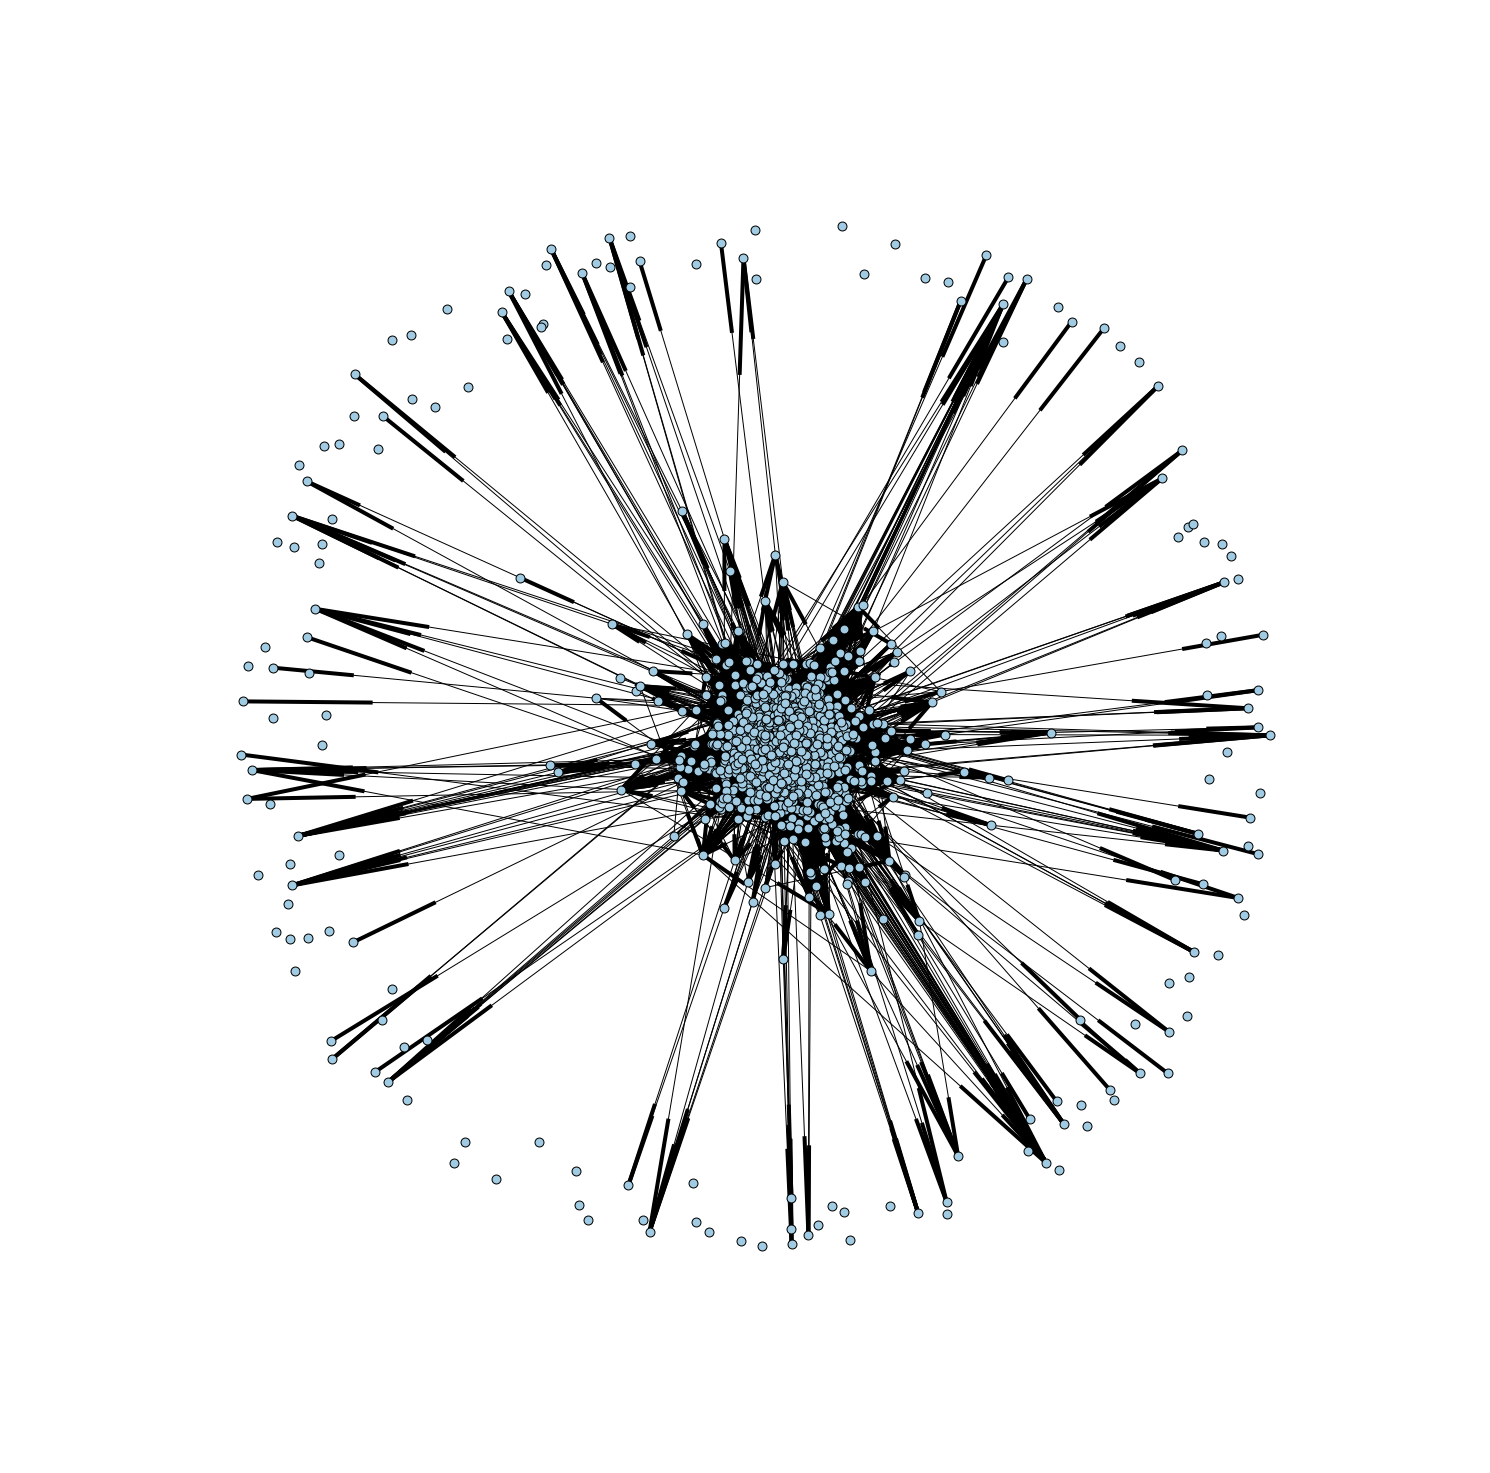

In [20]:
# Plot the graph
plt.figure(figsize=(20,20))
nx.draw(G, node_size=80, node_color="#A0CBE2")
plt.savefig("Hollywood_Graph.png", format="PNG")
plt.show()

Most of the stars are then linked to each other. The high average degree is caused by some stars that are simply connected to many others or the number of connections is evenly spread out. The degree distribution and degree assortativity coefficient will clarify this.

In [21]:
# Compute degree assortativity coefficient of undirected graph
deg_assort = nx.degree_assortativity_coefficient(G_ud)
print deg_assort

0.0131566352539


The degree assortativity coefficient is $r=0.0129205405915$, i.e. it is positive which indicates that nodes with same degrees are linked. This means that stars in the network with high degrees in the undirected graph are connected to stars with high degrees. That being said, $r$ is only slightly above zero and is in fact close to being negative, so nothing clear can be concluded here.

In [22]:
# Find stars' outgoing degrees by simply looking at their degrees in the graph
degrees_out = G.degree() #Dictionary of stars with their outgoing degrees as values

# Find stars' ingoing degrees by counting how many times they are pointed to
degrees_in = {} #Dictionary of philosophers with their ingoing degrees as values
for phil in G.nodes():
    count = 0
    for linkto in [edge[1] for edge in G.edges()]:
        if phil == linkto:
            count += 1
    degrees_in[phil] = count

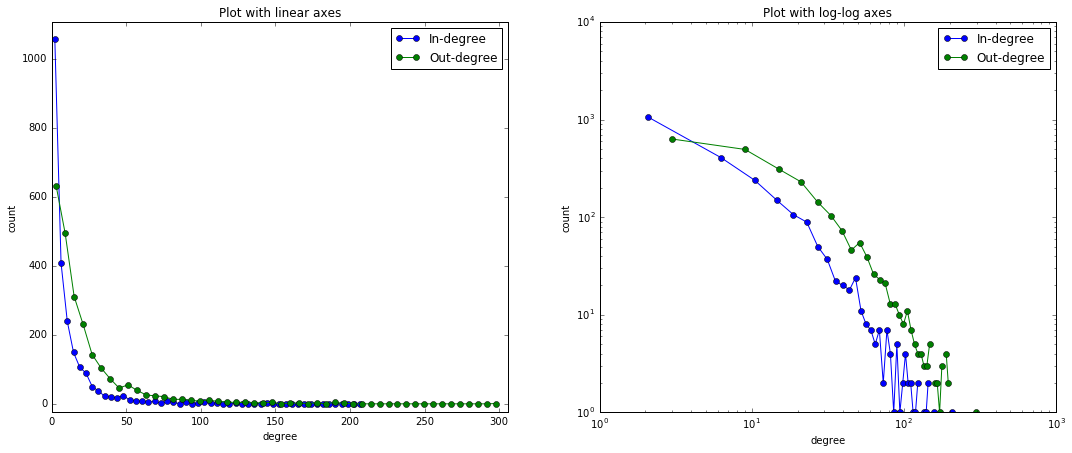

In [23]:
# Find min and max values for ingoing and outgoing degrees
min_deg_in = min(degrees_in.values())
max_deg_in = max(degrees_in.values())
min_deg_out = min(degrees_out.values())
max_deg_out = max(degrees_out.values())

# Bin the degree distributions
numBims = 50
bins_in = np.histogram(degrees_in.values(), bins=numBims)
bins_out = np.histogram(degrees_out.values(), bins=numBims)

# Find the centers for each bin
bin_centers_in = []
bin_centers_out = []
for i in range(len(bins_in[1])-1):
    center = (bins_in[1][i]+bins_in[1][i+1])/2
    bin_centers_in.append(center)
for i in range(len(bins_out[1])-1):
    center = (bins_out[1][i]+bins_out[1][i+1])/2
    bin_centers_out.append(center)
    
# Plot degree distributions with linear axis and log axis
plt.figure(figsize=(18, 7))

plt.subplot(121)
line1,=plt.plot(bin_centers_in, bins_in[0], 'bo-', label='In-degree')
line2,=plt.plot(bin_centers_out, bins_out[0], 'go-', label='Out-degree')
plt.axis([0, max(max_deg_in,max_deg_out)+5, -25, max(max(bins_in[0]),max(bins_out[0]))+50])
plt.xlabel('degree')
plt.ylabel('count')
plt.title('Plot with linear axes')
plt.legend(handles=[line1,line2])

plt.subplot(122)
line3,=plt.loglog(bin_centers_in, bins_in[0], 'bo-', label='In-degree')
line4,=plt.loglog(bin_centers_out, bins_out[0], 'go-', label='Out-degree')
plt.xlabel('degree')
plt.ylabel('count')
plt.title('Plot with log-log axes')
plt.legend(handles=[line3,line4])

plt.savefig('deg_dist.png')

The degree distribution above is found be binning degrees of all the network. The Numpy library in Python provides a way binning values using the "histogram" function. Clearly we can observe that many nodes have in- and out-degrees below the average, and yet there are also nodes with degrees much higher than the average. This does not contradict presence of a giant component, but rather encourages the idea that some stars are more central and we can find the most prominent in the network. There obviously is stars on the Hollywood Walk of Fame that appear on many other Wikipedia pages and have many outgoing links on their own wikipages.

## Part 3: Tools, theory and analysis
This project will have three steps in the analysis to examine the Hollywood Walk of Fame dataset.
* Outstanding stars (network wise) will be a central part of the network and we're looking for The STAR of stars. The idea is to find the top stars based on centrality to give us a great clue to which stars we should take our picture with! 4 different centrality measures will be considered here.
* Community detection will be used to see if the network resembles any group perons from the real world. So proposed networks will be created and their strength will be tested to see if the partition makes sense. Furthermore the Python Louvain algorithm will be used to find the best partition, maybe a sensible community is found here.
* The final part of the analysis is to look at the text on the Wikipedia pages to find simmilarities. The idea is that the persons with stars on the Hollywood Walk of Fame must have some words in common, these might suggest Hollywood stardom. Also combining text analysis with community detection can hopefully explain some of the communities, why specific gets group together.

### Centrality measures
It makes a lot of sense to look at centralities because it can detect important nodes in a network. I have chosen to implement a NetworkX graph because it is great way of representing a network, plus the library provides many useful functions explore networks some of which have already been used in project. There is also implemented multiple function to compute different centralities of a network. The following 4 centrality is included in the project.
* Degree centrality
* Betweenness centrality
* Eigenvector centrality
* Closeness centrality

Degree centrality is relatively simple as it counts the ingoing and outgoing degrees of nodes which is just a mtter of counting edges. This is done in using NetworkX in fact it has already been done in the Network statistics section above. NetworkX functions will be used in the constructed graph to compute the other centralities. Betweenness centrality is a measure of how much does a node appear in shortest paths of the graph. Eigenvector centrality is a measure of how connected a node is to other nodes that are connected to each other. So if many nodes are all connected to each other the eigenvector centrality will be high for them, while if a nodes is connected to other nodes that are not connected then the eigenvector centrality will low. Closeness centrality is calculated as the sum of the length of the shortest paths between the node and all other nodes in the graph. I.e. if the shortest paths to the other nodes are small the Closeness centrality will be higher. To summarize a node with high centrality in all categories, it will have many ingoing and out going edges, it will be part of many shortest paths in the network, its neighbors are well connected and the shortest path to all other nodes are as small as possible. Consider this for the Hollywood star network. The star would be connected with many others, it will known by most as a result of "friend of friend" connections and its connections are part of the inner circle in Hollywood. Centrality values from all 4 measures are stored in dictionaries. In the following code blocks the top 10 values from these dictionaries are extracted and printed with their keys.

In [24]:
# Degree centrality of a node is its number of links
# Extract top 10 items with highest in- and out-degrees from dictionaries
top10_in = sorted(degrees_in.iteritems(), key=lambda (k, v): (-v, k))[:10]
top10_out = sorted(degrees_out.iteritems(), key=lambda (k, v): (-v, k))[:10]

# Print top 10 stars with ingoing and outgoing links
print "Top 10 Hollywood Stars by in-degree:"
for i in range(10):
    print str(i+1) + ". " + top10_in[i][0] + ": " + str(top10_in[i][1])
print "\nTop 10 Hollywood Stars by out-degree:"
for i in range(10):
    print str(i+1) + ". " + top10_out[i][0] + ": " + str(top10_out[i][1])

Top 10 Hollywood Stars by in-degree:
1. Frank Sinatra: 209
2. Elvis Presley: 156
3. Associated Press: 146
4. Bing Crosby: 143
5. John Wayne: 142
6. Ronald Reagan: 135
7. Bob Hope: 124
8. Bette Davis: 123
9. The Simpsons: 120
10. Katharine Hepburn: 113

Top 10 Hollywood Stars by out-degree:
1. Frank Sinatra: 301
2. John Ford: 195
3. Cary Grant: 193
4. Bette Davis: 191
5. Bing Crosby: 189
6. Elvis Presley: 189
7. Gary Cooper: 189
8. James Stewart: 180
9. John Wayne: 178
10. Clark Gable: 177


In [25]:
# This is included as an extra way of telling which star is most outstanding
# Extract top 10 items with highest number of awards
top10_award = sorted(awards.iteritems(), key=lambda (k, v): (-v, k))[:10]

# Print top 10 stars with number og awards
print "Top 10 stars by award count:"
for i in range(10):
    print str(i+1) + ". " + top10_award[i][0] + ": " + str(top10_award[i][1])

Top 10 stars by award count:
1. Barbra Streisand: 24
2. Angela Lansbury: 23
3. Frank Sinatra: 22
4. Meryl Streep: 22
5. Katharine Hepburn: 19
6. Glenn Close: 18
7. John Lithgow: 18
8. Kelsey Grammer: 17
9. The Beatles: 17
10. Mary Tyler Moore: 16


In [26]:
# Betweenness centrality
# Calculate the betweenness centrality using NetworkX function. G is the directed NetworkX graph of wiki articles.
betw_cen = nx.betweenness_centrality(G)

# Extract top 10 items with highest betweenness centrality from dictionary
top10_betw = sorted(betw_cen.iteritems(), key=lambda (k, v): (-v, k))[:10]

# Print top 10 stars with highest betweenness centrality
print "Top 10 stars by betweenness centrality:"
for i in range(10):
    print str(i+1) + ". " + top10_betw[i][0] + ": " + str(top10_betw[i][1])

Top 10 stars by betweenness centrality:
1. Frank Sinatra: 0.0468286527605
2. Bing Crosby: 0.0197918150657
3. Elvis Presley: 0.0186095312697
4. John Ford: 0.0185678464721
5. Cary Grant: 0.0180000673372
6. Bette Davis: 0.0154683311439
7. Barbra Streisand: 0.0147183384349
8. Clark Gable: 0.0146330200913
9. Gary Cooper: 0.0146314350743
10. Dean Martin: 0.0144182293637


In [27]:
# Eigenvector centrality

# Compute eigenvector centrality using NetworkX

# Eigenvector centrality for in-degree
eig_cent_in = nx.eigenvector_centrality(G)

# Eigenvector centrality for out-degree, computed in the same way but with the reversed graph
eig_cent_out = nx.eigenvector_centrality(G.reverse())

# Extract top 10 items with highest eigenvector centrality from dictionaries
top10_eig_in = sorted(eig_cent_in.iteritems(), key=lambda (k, v): (-v, k))[:10]
top10_eig_out = sorted(eig_cent_out.iteritems(), key=lambda (k, v): (-v, k))[:10]

# Print top 10 stars with highest eigenvector centrality
print "Top 10 stars by eigenvector centrality for in-degree:"
for i in range(10):
    print str(i+1) + ". " + top10_eig_in[i][0] + ": " + str(top10_eig_in[i][1])
print "\nTop 10 stars by eigenvector centrality for out-degree:"
for i in range(10):
    print str(i+1) + ". " + top10_eig_out[i][0] + ": " + str(top10_eig_out[i][1])

Top 10 stars by eigenvector centrality for in-degree:
1. Frank Sinatra: 0.176314481063
2. Clark Gable: 0.151389133974
3. Katharine Hepburn: 0.150049348951
4. Cary Grant: 0.148356657804
5. James Stewart: 0.144524728965
6. Bette Davis: 0.141184833155
7. Ronald Reagan: 0.137365260468
8. Humphrey Bogart: 0.132941175701
9. Gary Cooper: 0.127615529858
10. Joan Crawford: 0.118617815643

Top 10 stars by eigenvector centrality for out-degree:
1. George Cukor: 0.178050821131
2. John Ford: 0.144535299704
3. George Raft: 0.140235147926
4. James Stewart: 0.138779976871
5. Gary Cooper: 0.128302541022
6. Humphrey Bogart: 0.125541583141
7. Cary Grant: 0.121523735438
8. Howard Hawks: 0.120329240159
9. Michael Curtiz: 0.119975163232
10. Clark Gable: 0.11812943045


In [28]:
# Closeness centrality

# This centrality measure assumes that the graph is connected, i.e. all nodes have at least one edge
# First test if all nodes have et least one edge
G_ud = G.to_undirected()
print "The graph is connected: " + str(nx.is_connected(G_ud))

# Closeness cenrrality can still be computed, unreachable nodes does just not contribute
# Compute closeness centrality using NetworkX

# Closeness centrality for in-degree
close_cent_in = nx.closeness_centrality(G)

# Extract top 10 items with highest closeness centrality from dictionaries
top10_close = sorted(close_cent_in.iteritems(), key=lambda (k, v): (-v, k))[:10]

# Print top 10 stars with highest closeness centrality
print "Top 10 stars by closeness centrality:"
for i in range(10):
    print str(i+1) + ". " + top10_close[i][0] + ": " + str(top10_close[i][1])

The graph is connected: False
Top 10 stars by closeness centrality:
1. Frank Sinatra: 0.311411501139
2. George Cukor: 0.309663050761
3. Cary Grant: 0.309414873602
4. James Stewart: 0.309167093923
5. George Raft: 0.307199051949
6. Michael Curtiz: 0.30707688092
7. John Ford: 0.306650046495
8. Howard Hawks: 0.304533550413
9. Gary Cooper: 0.300913802445
10. Mae West: 0.299455038617


It is quite clear which person comes out on top when we are looking at centralities. Frank Sinatra was one of the most popular and influential musical artists of the 20th century, so it makes sense that he is our outstanding star. He was an actor and producer winning awards in more than one entertainment field. I suggest you remember to photograph his star if you ever find youself in the Hollywood Walk of Fame. This is all based on centrality measures, which corresponds well with the ideas of fame and influence in the Hollywood star network.

### Community detection
To detect some hidden communities in the network we can find the best partition and then in text analysis process the texts of persons in partition's communities. This let us know what words are essential for communities and hopefully this reveals what kind of community it is. For now we are just finding and testing proposed communities by looking at their modularities. Modularity measure the strength of division of a network into groups, so it can be used as meassure of how good a proposed community is. It should be noted the modularity struggles and is unable to detect small communities.

In this section we will the created data structures from earlier in the project is used. Looking at the graph and the lists and dictionaries of fictional characters, awards, lonely stars and star categories we can divide the network into groups in different ways. But first we are going to find the best partition found using the Python Louvain algorithm. This is found in the community library. In the code block below we are using the algorithm and saving communities containing more than 1 star in sets.

In [29]:
# Compute the best partition using Louvain-algorithm in Python
part = community.best_partition(G_ud)

# Find number of communities
n_c = 0
for node in part:
    if part[node] > n_c:
        n_c = part[node]
print "Number of communities in partition: " + str(n_c+1)

# Put nodes into sets that correspond to communities
part_sets = [set() for i in range(n_c+1)]
for node in part:
    part_sets[part[node]].add(node)
    
count = 0
for group in part_sets:
    if len(group) != 1:
        print len(group)
    else:
        count += 1
print "Number of communities containing only 1 star: " + str(count)

# How many stars in communities?
count = 0
print "Communities with more than one star: "
star_comms = []
for idx, comm in enumerate(part_sets):
    if len(comm) > 1:
        print idx
        star_comms.append(idx)
    if len(comm) == 1:
        count += 1

Number of communities in partition: 109
379
425
605
364
275
25
57
63
2
2
2
Number of communities containing only 1 star: 98
Communities with more than one star: 
0
1
2
3
4
7
8
9
16
37
89


Analysis showed the there are many communities consisting of a single person. These will not be explored further. Instead the list of lonely stars from earlier will considered a community in the analysis. Later we can use text analysis to see what kind of stars are in the different groups.

The Python Louvain algorithm finds the best partition so now we can what a reasonably high modularity is for the network.

In [30]:
# Calculate the modularity using eqution 9.12 in the Network Science book

# Function to compute equation 9.12
def partition_modularity(G, communities):
    L = float(len(G.edges())) #Total number of links in graph
    n_c = len(communities) #Number of communities
    L_c = [0.0 for i in range(n_c)] #Number of links in communities
    k_c = [0.0 for i in range(n_c)] #Total degree of the nodes in communities
    
    for idx, c in enumerate(communities):
        for node in c:
            L_c[idx] += len(G.edges(node))
            k_c[idx] += G.degree(node)
    
    M = 0
    for i in range(n_c):
        M += (L_c[i]/L)-(k_c[i]/(2*L))**2
    return M

In [31]:
# Calculate modularity for this partition
M_part = partition_modularity(G, part_sets)
print "Modularity for this partition: " + str(M_part)

Modularity for this partition: 0.785901174005


Now there a value of modulairty to compare with. The following code blocks creates proposed communities and finds calculates their modularities. I could definitely image that there is community of people in the Motion picture industry (actors, producers, etc.), because there is whole network to be build about who has collaberated with who. Same can be said about persons in the Audio recording category.

In [32]:
# Put stars of different categories in communities represented as sets
# Index follows (Motion pictures, Televsion, Radio, Recording, Live performance)
cat_comms = [set() for i in range(5)]
for star in G.nodes():
    if stars_cat.get(star) == None:
        continue
    elif stars_cat[star] == 'Motion pictures':
        cat_comms[0].add(star)
    elif stars_cat[star] == 'Television':
        cat_comms[1].add(star)
    elif stars_cat[star] == 'Recording':
        cat_comms[2].add(star)
    elif stars_cat[star] == 'Radio':
        cat_comms[3].add(star)
    elif stars_cat[star] == 'Live performance':
        cat_comms[4].add(star)
        
# How many stars in each category?
for cat in cat_comms:
    print len(cat)
# The count does corresponds exactly with number of stars in network
# This is caused by not all categories to stars was found

1126
483
420
188
44


In [33]:
# Some nodes will not be included in the category communities because they are not in any of the 5 regular categories
print "Category of Victoria's Secret: " + stars_cat["Victoria's Secret#Victoria's Secret Angels"]

Category of Victoria's Secret: Special


In [34]:
# Put stars with awards in community and stars without in community
award_comms = [set() for i in range(2)]
for star in G.nodes():
    if awards.get(star) == None:
        continue
    elif awards[star] == 0:
        award_comms[0].add(star)
    elif awards[star] > 0:
        award_comms[1].add(star)

# How many stars in each community?
for comm in award_comms:
    print len(comm)

1674
623


In [35]:
# Put stars of fictional characters in community
fict_comm = set()
for star in fict_stars:
    if G.has_node(star):
        fict_comm.add(star)

# How many fictional characters in community?
print len(fict_comm)

21


In [36]:
# Calculate modularities for different partitions
modularity_best = partition_modularity(G, part_sets)
print "Modularity for best partition: " + str(modularity_best)
modularity_cat = partition_modularity(G, cat_comms)
print "Modularity for category partition: " + str(modularity_cat)
modularity_award = partition_modularity(G, award_comms)
print "Modularity for award partition: " + str(modularity_award)
modularity_fict = partition_modularity(G, [fict_comm])
print "Modularity for community of fictional characters: " + str(modularity_fict)

Modularity for best partition: 0.785901174005
Modularity for category partition: 0.569863656493
Modularity for award partition: 0.495028596335
Modularity for community of fictional characters: 0.00600644025651


The modularities of proposed communities are not are close and not way off the modularity of the best partition except for the modularity for community of fictional characters, but this should not be considered a partition, since they is only included 21 stars of the network. The best partition seems to be the most interesting as the communities here are noticeably stronger. There are 11 chosen communities and in the text analysis we can try to explain them. Most of the code above is basic coding functionalities, loops and conditional statements used on data structures.

The best partition is plotted below. Notice that there definitely groups with many nodes in them, and these groups also seem to be part of the giant component.

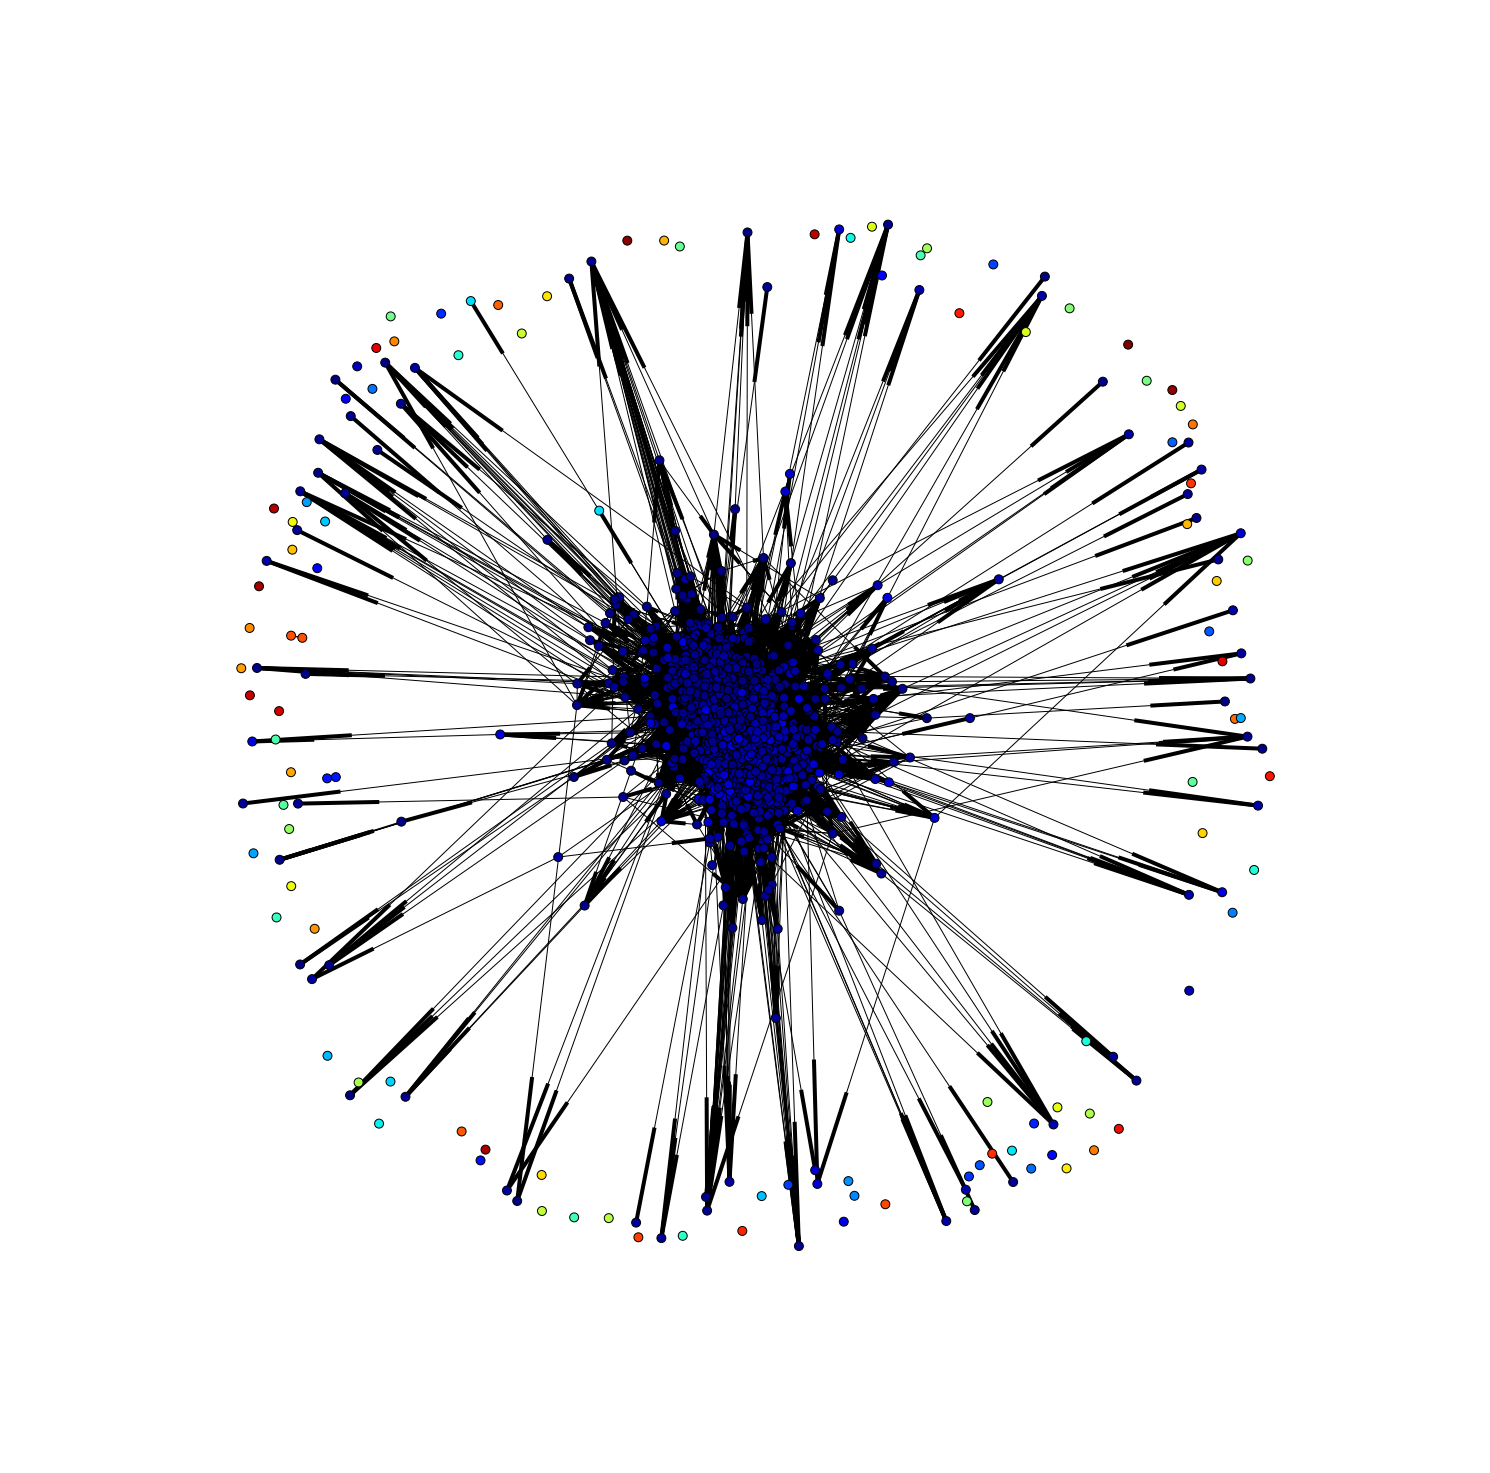

In [37]:
# Plot the graph
part = community.best_partition(G_ud)
values = [part.get(node) for node in G.nodes()]
plt.figure(figsize=(20,20))
nx.draw_spring(G, cmap=plt.get_cmap('jet'), node_color=values, node_size=80, with_labels=False)
plt.savefig("Hollywood_Graph_partition.png", format="PNG")

### Text analysis
In order to say something general about the Hollywood star network we can common keywords. This idea will also be applied to the communities found above. The way to identify relevant words in this project is inspired by what we have done previously in the course. Elements from natural language processing will used. Tokenization being very important. We will tokenize each wikipage texts and store the words in lists, so the become easier to work with. It is also important to remove stopwords as we are going to look at word frequencies among other things, and highly frequent words like "the" will disturb the data. Once the texts are tokenized we combine the lists of tokens to one large document, so we are basically combining all wikipages to one document. This especially becomes relevant when looking at communities, then there will be one document for each community.

In [38]:
# Define function to tokenize and exclude the right elements from text like stopwords
def tokenize(text):
    # Tokenize text using same approach as in textbook, ch. 3.7. Exclude digits and punctuation.
    re_tokens = nltk.regexp_tokenize(text, r"\w+") 
    
    # Remove stopwords and standalone letters while setting to lowercase
    tokens = []
    for token in re_tokens:
        if (token.lower() not in stopwords.words('english')
            and token.lower() not in list(string.ascii_lowercase)):
            tokens.append(token.lower())
            
    return tokens

In [39]:
# Tokenize the pages and generate one large documents
doc = [] #List to contain tokens for each star wikipage

# For each star tokenize text and extend it to document
star_count = 0
for star in G.nodes():
    # Read wikipage from file in folder 'star_wikipages'
    name = re.sub('[ ]', '_', star)
    file_name = "star_wikipages/" + name
    f = open(file_name, "r")
    wikipage = json.dumps(f.read())
    f.close()
    tokens = list(set(tokenize(wikipage))) #List of words on star wikipage
    doc.extend(tokens)
    # Print progress
    star_count += 1
    if 100.0*star_count/len(G.nodes()) % 5 < 0.05:
        print "The loop is %f percent done" % (100.0*star_count/len(G.nodes()))
        
# Length of large documents
print len(doc)

The loop is 0.043535 percent done
The loop is 5.006530 percent done
The loop is 10.013061 percent done
The loop is 15.019591 percent done
The loop is 20.026121 percent done
The loop is 25.032651 percent done
The loop is 30.039182 percent done
The loop is 35.002177 percent done
The loop is 35.045712 percent done
The loop is 40.008707 percent done
The loop is 45.015237 percent done
The loop is 50.021768 percent done
The loop is 55.028298 percent done
The loop is 60.034828 percent done
The loop is 65.041358 percent done
The loop is 70.004354 percent done
The loop is 70.047889 percent done
The loop is 75.010884 percent done
The loop is 80.017414 percent done
The loop is 85.023944 percent done
The loop is 90.030475 percent done
The loop is 95.037005 percent done
The loop is 100.000000 percent done
1779139


A great tool for information retrievel is TF-IDF statistics. This stands for term frequency–inverse document frequency and is basically a way to determine how important words in a collection of documents are. This is why we combine wikipages to large documents. Higher values in the TF-IDF vector means more important words. The TF-IDF vector for a collection document (representing say a partition into communities) will have TF-IDF values for each unique word in all the documents. I will represent TF-IDF vectors as dictionaries in python, keys being words and values being the calculated TF-IDF values. Term frequency (TF) is just how often a word appears in the documents. In this project simple raw term frequency is used. Inverse document frequency (IDF) is a measure of how common a word is by looking at how many different document it is in. IDf will therefore decrease the importance of very common words appearing in all documents. The following code will find the TF-IDF vector for the one large document combining all nodes in the Hollywood star network.

In [40]:
# Convert list of tokens to dictionary of unique tokens with their count as values
# This can be used for TF values for the large document
token_dic = {}

# Count occurence of each word in the large document
for token in doc:
    if token not in token_dic:
        token_dic[token] = 1
    else:
        token_dic[token] += 1

# Print number of total count for dictionary. Should be equal to length of star document
print sum(token_dic.values())

1779139


In [41]:
# Calculate IDF
token_idf = {} #Dictionary of each unique word with its IDF as value

# Count occurence of each word in the large document
for token in doc:
    if token not in token_idf:
        token_idf[token] = 1
    else:
        token_idf[token] += 1
# Now calculate IDF for each word. Logarithm with 1000 base is used
for token in token_idf:
    token_idf[token] = math.log(float(len(G.nodes()))/(token_idf[token]), 1000)

In [42]:
# Calcualte TF-IDF for each branch
tf_idf = {} #List to contain TF-IDF for each token in star wikipages

for token in token_dic:
    tf_idf[token] = token_dic[token] * token_idf[token]

In [43]:
# Print top 10 words in terms TF-IDF
top10_tf_idf = sorted(tf_idf.iteritems(), key=lambda (k, v): (-v, k))[:10]
print "Top 10 tokens:"
for j in range(10):
    print top10_tf_idf[j][0] + ": " + str(top10_tf_idf[j][1])

Top 10 tokens:
theatre: 122.329040626
book: 122.328958268
industry: 122.328951664
met: 122.328704793
still: 122.328704793
season: 122.32869118
history: 122.328280404
15: 122.328258971
lived: 122.327654831
top: 122.326878557


A way to visualize the important words found in the text analysis is using a word cloud. We can use the wordcloud library in Python to do this. The way this works is that the WordCloud "generate" function will construct the word cloud of a given text. Since we have stored the importance scores in a dictionary ("tf_idf") we need to convert this to an actual text, a string. This can simply be done by inserting the words in accordance with TF-IDF values. That is, if a word has a value of 5 it is put into the string 5 times.

The loop is 0.000955 percent done
The loop is 5.000287 percent done
The loop is 10.000573 percent done
The loop is 15.000860 percent done
The loop is 20.000191 percent done
The loop is 25.000478 percent done
The loop is 30.000764 percent done
The loop is 35.000096 percent done
The loop is 40.000382 percent done
The loop is 45.000669 percent done
The loop is 50.000000 percent done
The loop is 50.000955 percent done
The loop is 55.000287 percent done
The loop is 60.000573 percent done
The loop is 65.000860 percent done
The loop is 70.000191 percent done
The loop is 75.000478 percent done
The loop is 80.000764 percent done
The loop is 85.000096 percent done
The loop is 90.000382 percent done
The loop is 95.000669 percent done
The loop is 100.000000 percent done


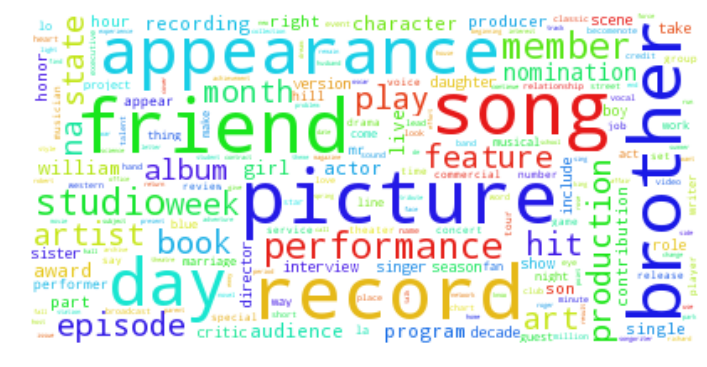

In [44]:
# Convert tokens in documents into long strings using TF-IDF scores
text = ""
token_count = 0
for token in tf_idf:
    for i in range(int(tf_idf[token])):
        text = text + " " + token
    # Print progress
    token_count += 1
    if 100.0*token_count/len(tf_idf) % 5 < 0.001:
        print "The loop is %f percent done" % (100.0*token_count/len(tf_idf))

# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(max_font_size=45,
                      background_color='white').generate(text)
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis("off")

pic_name = 'word_cloud_all.png'
plt.savefig(pic_name)

plt.show()

These words clearly relate to Hollywood stars, as they relate to the entertainment industry with words like "record", "picture", "performance", "studio", "artist". "brother" and "friend" are apparently important keywords in this network. In general though this wordcloud makes a lot of sense when comparing it to the subject matter. Computing IDF values for the TF-IDF vector involves a logarithm from mathematics. Different bases for this logarithm was tested with trial-and-error until the end result was reasonable.

Let's now do the same text analysis on the communities found in the section above. Much of the code below contain similar elements just applied to different partitions. Keep in mind that the different partitions contain different numbers of communities and there is a word cloud for each community, but they will not all be shown in this notebook. They are part of the project and have been considered.

#### Best partition

In [45]:
# Now find similarities for communities. Best partition and lonely stars
# We can include lonely stars as an extra community of stars from the best partition's single star communities

# Tokenize the pages and generate one large documents

# List to contain large document for each star community
docs = [[] for i in range(len(star_comms)+1)]

# Iterate through each community in best partition
for i in range(len(docs)-1):
    # For each star tokenize text and extend it to document
    for star in part_sets[i]:
        # Read wikipage from file in folder 'star_wikipages'
        name = re.sub('[ ]', '_', star)
        file_name = "star_wikipages/" + name
        f = open(file_name, "r")
        wikipage = json.dumps(f.read())
        f.close()
        tokens = list(set(tokenize(wikipage))) #List of words on star wikipage
        docs[i].extend(tokens)
    # Print progress
    print "Done with community %d out of %d" % (i+1, len(docs))
# Create large document for 'lonely stars'
for star in lonely_stars:
        # Read wikipage from file in folder 'star_wikipages'
        name = re.sub('[ ]', '_', star)
        file_name = "star_wikipages/" + name
        f = open(file_name, "r")
        wikipage = json.dumps(f.read())
        f.close()
        tokens = list(set(tokenize(wikipage))) #List of words on star wikipage
        docs[len(docs)-1].extend(tokens)
# Print progress
print "Done with community %d out of %d" % (len(docs), len(docs))
        
# Length of documents (lists)
for doc in docs:
    print len(doc)

Done with community 1 out of 12
Done with community 2 out of 12
Done with community 3 out of 12
Done with community 4 out of 12
Done with community 5 out of 12
Done with community 6 out of 12
Done with community 7 out of 12
Done with community 8 out of 12
Done with community 9 out of 12
Done with community 10 out of 12
Done with community 11 out of 12
Done with community 12 out of 12
343187
448832
397699
249533
219859
67
41
11026
51778
36738
25
35234


In [46]:
# Combine all steps of the TF-IDF approach in one function

def create_tf_idf(docs, log_base, output_option):
    # Convert lists of tokens to dictionaries of unique tokens with their count as values
    # This can be used for TF values for the large document
    token_dics = [{} for i in range(len(docs))]

    for idx, doc in enumerate(docs):
        for token in doc:
            if token not in token_dics[idx]:
                token_dics[idx][token] = 1
            else:
                token_dics[idx][token] += 1

    # Print number of total count for each dictionary. Should be equal to length of community documents
    for dic in token_dics:
        print sum(dic.values())

    # Calculate IDF
    token_idf = {} #Dictionary of each unique word in all documents with its IDF as value

    # Count occurence of each word in the documents
    for doc in token_dics:
        for token in doc:
            if token not in token_idf:
                token_idf[token] = 1
            else:
                token_idf[token] += 1
    # Now calculate IDF for each word. Logarithm with log_base base is used
    for token in token_idf:
        token_idf[token] = math.log(float(len(docs))/(token_idf[token]), log_base)

    # Calcualte tf-idf for each community
    tf_idf_comms = [{} for i in range(len(token_dics))] #List to contain TF-IDF for each token in each community

    for idx, doc in enumerate(token_dics):
        for token in doc:
            tf_idf_comms[idx][token] = doc[token] * token_idf[token]
    
    if output_option == 'TF':
        return token_dics
    elif output_option == 'IDF':
        return token_idf
    elif output_option == 'TF-IDF':
        return tf_idf_comms
    else:
        return "Invalid output_option"

In [47]:
# Look at western community, Yeehaw!
# This community from the best partition has "western" as a keyword and contains classical western actors.
part_sets[7]

{'Anne Shirley (actress)',
 'Annette Kellerman',
 'Art Acord',
 'Barbara Britton',
 'Bessie Barriscale',
 'Dale Evans',
 'Dick Jones (actor)',
 'Elena Verdugo',
 'Gail Davis',
 'Gene Autry',
 'Henry Rowland (actor)',
 'Hoot Gibson',
 'Jack Holt (actor)',
 'Jane Darwell',
 'Jimmy Wakely',
 'Ken Maynard',
 'Mabel Taliaferro',
 'Pat Buttram',
 'Rex Allen',
 'Richard Denning',
 'Roy Rogers',
 'Smiley Burnette',
 'Tex Williams',
 'Tom Mix',
 'William Boyd (actor)'}

In [49]:
# Create TF-IDF values for each category community
tf_idf_comms = create_tf_idf(docs, 100, 'TF-IDF')

343187
448832
397699
249533
219859
67
41
11026
51778
36738
25
35234


In [50]:
# Print top 10 words for each community
for i in range(len(tf_idf_comms)):
    # Extract top 10 items with highest TF-IDF from dictionaries
    top10 = sorted(tf_idf_comms[i].iteritems(), key=lambda (k, v): (-v, k))[:10]
    print "\nTop 10 tokens for community %d:" % (i+1)
    for j in range(10):
        print top10[j][0] + ": " + str(top10[j][1])


Top 10 tokens for community 1:
also: 23.0511969042
american: 22.6763806944
nominations: 22.4719877792
life: 22.2390951163
nin: 22.1141563797
references: 21.8642789065
early: 21.8018095381
first: 21.8018095381
one: 21.7393401698
two: 21.6768708015

Top 10 tokens for community 2:
chart: 38.0802944515
grammy: 31.0160247994
vocals: 28.4473345902
discography: 26.0615063402
also: 25.3625635315
american: 25.2376247949
one: 24.9877473217
references: 24.9252779534
nin: 24.8003392167
first: 24.4255230069

Top 10 tokens for community 3:
hollywood: 34.9828462503
references: 34.4830913039
american: 33.9833363575
films: 33.7959282525
died: 33.7334588842
life: 33.0462958329
star: 32.5465408865
first: 31.7969084668
also: 31.422092257
married: 30.7973985739

Top 10 tokens for community 4:
references: 21.0521771185
american: 20.739830277
also: 20.5524221721
hollywood: 19.3655041743
one: 19.3655041743
first: 19.2405654377
show: 19.1780960694
years: 18.8032798595
new: 18.7408104912
star: 18.6158717546

T

The loop is 15.000922 percent done
The loop is 20.000461 percent done
The loop is 25.000000 percent done
The loop is 40.000922 percent done
The loop is 45.000461 percent done
The loop is 50.000000 percent done
The loop is 65.000922 percent done
The loop is 70.000461 percent done
The loop is 75.000000 percent done
The loop is 90.000922 percent done
The loop is 95.000461 percent done
The loop is 100.000000 percent done


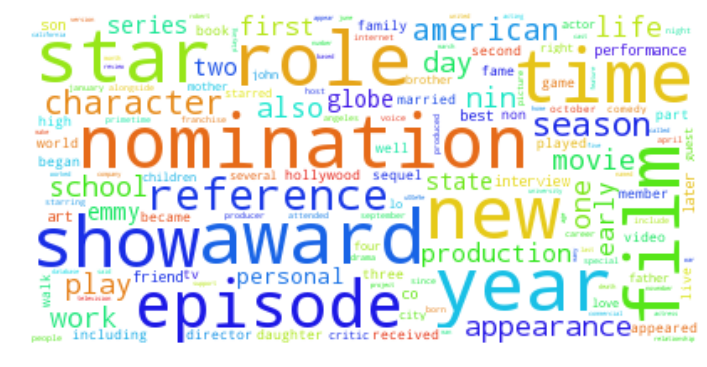

In [51]:
# Convert tokens in documents into long strings using TF-IDF scores
communityNum = 0 #This number represents what community in the partition the word cloud is for
text = ""
token_count = 0
for token in tf_idf_comms[communityNum]:
    for i in range(int(tf_idf_comms[communityNum][token])):
        text = text + " " + token
    # Print progress
    token_count += 1
    if 100.0*token_count/len(tf_idf_comms[communityNum]) % 5 < 0.001:
        print "The loop is %f percent done" % (100.0*token_count/len(tf_idf_comms[communityNum]))

# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(max_font_size=45,
                      background_color='white').generate(text)
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis("off")

pic_name = 'word_cloud_' + str(communityNum+1) + '.png'
#plt.savefig(pic_name)

plt.show()

Word clouds for community 1 and community 2 clearly shows that they are communities of actors and singers. The first cloud shows words like "film", "role", "show", "episode" while the second cloud has words like "grammy", "concert", "song" and "vocal". There are words you could link to the entertainment industry in the first 5 clouds. It should be noted that there are communities that contain very few stars, so keywords become less general.

#### Category communities

In [52]:
# Now find similarities for communities. category communities
# Tokenize the pages and generate one large documents

# List to contain large document for each star community
docs = [[] for i in range(len(cat_comms))]

# Iterate through each category community
for i in range(len(docs)):
    # For each star tokenize text and extend it to document
    for star in cat_comms[i]:
        # Read wikipage from file in folder 'star_wikipages'
        name = re.sub('[ ]', '_', star)
        file_name = "star_wikipages/" + name
        f = open(file_name, "r")
        wikipage = json.dumps(f.read())
        f.close()
        tokens = list(set(tokenize(wikipage))) #List of words on star wikipage
        docs[i].extend(tokens)
    # Print progress
    print "Done with community %d out of %d" % (i+1, len(docs))
        
# Length of documents (lists)
for doc in docs:
    print len(doc)

Done with community 1 out of 5
Done with community 2 out of 5
Done with community 3 out of 5
Done with community 4 out of 5
Done with community 5 out of 5
851318
315726
441101
101643
39107


In [53]:
# Create TF-IDF values for each category community
tf_idf_comms = create_tf_idf(docs, 100, 'TF-IDF')

851318
315726
441101
101643
39107


In [54]:
# Print top 10 words for each community
for i in range(len(tf_idf_comms)):
    # Extract top 10 items with highest TF-IDF from dictionaries
    top10 = sorted(tf_idf_comms[i].iteritems(), key=lambda (k, v): (-v, k))[:10]
    print "\nTop 10 tokens for community %d:" % (i+1)
    for j in range(10):
        print top10[j][0] + ": " + str(top10[j][1])


Top 10 tokens for community 1:
1929: 15.6025120943
vitagraph: 12.581460078
1920s: 12.1622066325
1920: 12.113751626
wampas: 11.8824900737
thalberg: 11.3412902472
lasky: 10.1474702211
beery: 9.55056020813
sennett: 9.55056020813
ince: 9.43609505854

Top 10 tokens for community 2:
miniseries: 3.68258049431
sci: 2.88403374501
groening: 2.79588001734
estate: 2.56811534471
howie: 2.38764005203
bogart: 2.21848749616
conan: 2.21848749616
produce: 2.18047529268
rockford: 2.10756312136
u20132000: 2.10756312136

Top 10 tokens for community 3:
keyboards: 9.15262019946
airplay: 7.43193311215
riffs: 6.64021504119
guitarists: 6.56601014309
instrumentalist: 6.36704013875
chaka: 6.29073003902
allmusic: 6.15378582601
cma: 5.94124503686
aguilera: 5.57116012141
musicianship: 5.57116012141

Top 10 tokens for community 4:
kfi: 2.7855800607
ndunning: 2.44639501518
1929: 1.93820026016
kewb: 1.74742501084
507678: 1.39794000867
chuckle: 1.39794000867
krth: 1.39794000867
kxla: 1.39794000867
whittinghill: 1.39794

The loop is 5.000195 percent done
The loop is 10.000390 percent done
The loop is 15.000585 percent done
The loop is 20.000779 percent done
The loop is 25.000974 percent done
The loop is 50.000000 percent done
The loop is 55.000195 percent done
The loop is 60.000390 percent done
The loop is 65.000585 percent done
The loop is 70.000779 percent done
The loop is 75.000974 percent done
The loop is 100.000000 percent done


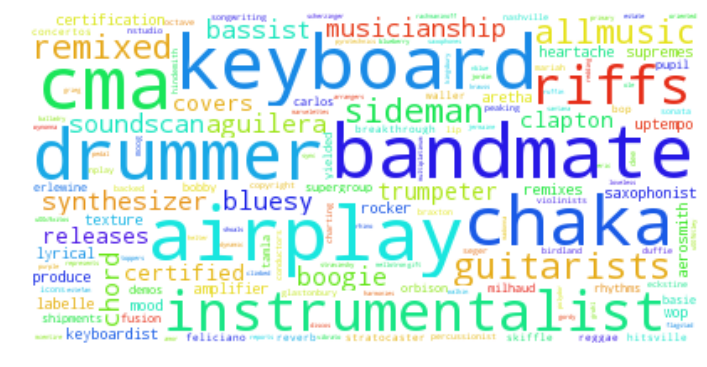

In [55]:
# Convert tokens in documents into long strings using TF-IDF scores
communityNum = 2 #This number represents what community in the partition the word cloud is for
text = ""
token_count = 0
for token in tf_idf_comms[communityNum]:
    for i in range(int(tf_idf_comms[communityNum][token])):
        text = text + " " + token
    # Print progress
    token_count += 1
    if 100.0*token_count/len(tf_idf_comms[communityNum]) % 5 < 0.001:
        print "The loop is %f percent done" % (100.0*token_count/len(tf_idf_comms[communityNum]))

# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(max_font_size=45,
                      background_color='white').generate(text)
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis("off")

pic_name = 'word_cloud_category_' + str(communityNum+1) + '.png'
plt.savefig(pic_name)

plt.show()

It is quite easy to detect which cloud is build from the Audio recording category. The other word clouds represent the other categories which is not clear at all. It is in fact not easy to conclude anything from these word cloud at all.

#### Award communities

In [56]:
# Now find similarities for communities. award communities
# Tokenize the pages and generate one large documents

# List to contain large document for each star community
docs = [[] for i in range(len(award_comms))]

# Iterate through each award community
for i in range(len(docs)):
    # For each star tokenize text and extend it to document
    for star in award_comms[i]:
        # Read wikipage from file in folder 'star_wikipages'
        name = re.sub('[ ]', '_', star)
        file_name = "star_wikipages/" + name
        f = open(file_name, "r")
        wikipage = json.dumps(f.read())
        f.close()
        tokens = list(set(tokenize(wikipage))) #List of words on star wikipage
        docs[i].extend(tokens)
    # Print progress
    print "Done with community %d out of %d" % (i+1, len(docs))
        
# Length of documents (lists)
for doc in docs:
    print len(doc)

Done with community 1 out of 2
Done with community 2 out of 2
1124806
654333


In [57]:
# Create TF-IDF values for each award community
tf_idf_comms = create_tf_idf(docs, 100, 'TF-IDF')

1124806
654333


In [58]:
# Print top 10 words for each community
for i in range(len(tf_idf_comms)):
    # Extract top 10 items with highest TF-IDF from dictionaries
    top10 = sorted(tf_idf_comms[i].iteritems(), key=lambda (k, v): (-v, k))[:10]
    print "\nTop 10 tokens for community %d:" % (i+1)
    for j in range(10):
        print top10[j][0] + ": " + str(top10[j][1])


Top 10 tokens for community 1:
brahms: 3.3113299523
kabc: 3.16081495447
u00e9ma: 2.85978495881
kfi: 2.55875496314
woodpecker: 2.55875496314
rodeos: 2.40823996531
utilizing: 2.40823996531
128: 2.10720996965
ampas: 2.10720996965
cellist: 2.10720996965

Top 10 tokens for community 2:
dench: 1.80617997398
ritt: 1.65566497615
elle: 1.50514997832
glaucoma: 1.35463498049
instinctively: 1.20411998266
aldwych: 1.05360498482
anouilh: 1.05360498482
bening: 1.05360498482
fierstein: 1.05360498482
grandfathers: 1.05360498482


The loop is 5.000827 percent done
The loop is 10.000473 percent done
The loop is 15.000118 percent done
The loop is 20.000946 percent done
The loop is 25.000591 percent done
The loop is 30.000236 percent done
The loop is 40.000709 percent done
The loop is 45.000355 percent done
The loop is 50.000000 percent done
The loop is 55.000827 percent done
The loop is 60.000473 percent done
The loop is 65.000118 percent done
The loop is 70.000946 percent done
The loop is 75.000591 percent done
The loop is 80.000236 percent done
The loop is 90.000709 percent done
The loop is 95.000355 percent done
The loop is 100.000000 percent done


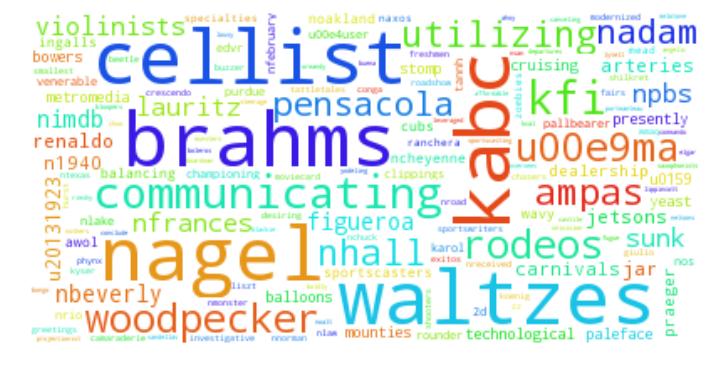

In [59]:
# Convert tokens in documents into long strings using TF-IDF scores
communityNum = 0 #This number represents what community in the partition the word cloud is for
text = ""
token_count = 0
for token in tf_idf_comms[communityNum]:
    for i in range(int(tf_idf_comms[communityNum][token])):
        text = text + " " + token
    # Print progress
    token_count += 1
    if 100.0*token_count/len(tf_idf_comms[communityNum]) % 5 < 0.001:
        print "The loop is %f percent done" % (100.0*token_count/len(tf_idf_comms[communityNum]))

# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(max_font_size=45,
                      background_color='white').generate(text)
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis("off")

pic_name = 'word_cloud_award_' + str(communityNum+1) + '.png'
plt.savefig(pic_name)

plt.show()

#### Fictional character community
This section is included because it might be fun to see if we can detect some Hollywood related words in the wikipages for fictional characters. I expect to see words like "cartoon" and "animated".

In [60]:
# Now find similarities for fictional character community
# Tokenize the pages and generate one large documents

# List to contain large document for each star community
docs = [[] for i in range(len([fict_comm]))]

# Iterate through each award community
for i in range(len(docs)):
    # For each star tokenize text and extend it to document
    for star in fict_comm:
        # Read wikipage from file in folder 'star_wikipages'
        name = re.sub('[ ]', '_', star)
        file_name = "star_wikipages/" + name
        f = open(file_name, "r")
        wikipage = json.dumps(f.read())
        f.close()
        tokens = list(set(tokenize(wikipage))) #List of words on star wikipage
        docs[i].extend(tokens)
    # Print progress
    print "Done with community %d out of %d" % (i+1, len(docs))
        
# Length of documents (lists)
for doc in docs:
    print len(doc)

Done with community 1 out of 1
27964


In [61]:
# Create TF-IDF values for fictional character community
tf_idf_comms = create_tf_idf(docs, 100, 'TF')

27964


In [62]:
# Print top 10 words for each community
for i in range(len(tf_idf_comms)):
    # Extract top 10 items with highest TF-IDF from dictionaries
    top10 = sorted(tf_idf_comms[i].iteritems(), key=lambda (k, v): (-v, k))[:10]
    print "\nTop 10 tokens for community %d:" % (i+1)
    for j in range(10):
        print top10[j][0] + ": " + str(top10[j][1])


Top 10 tokens for community 1:
0: 21
1: 21
20: 21
article: 21
batchcomplete: 21
exlimit: 21
extract: 21
extracts: 21
film: 21
first: 21


The loop is 45.000879 percent done
The loop is 50.000000 percent done
The loop is 95.000879 percent done
The loop is 100.000000 percent done


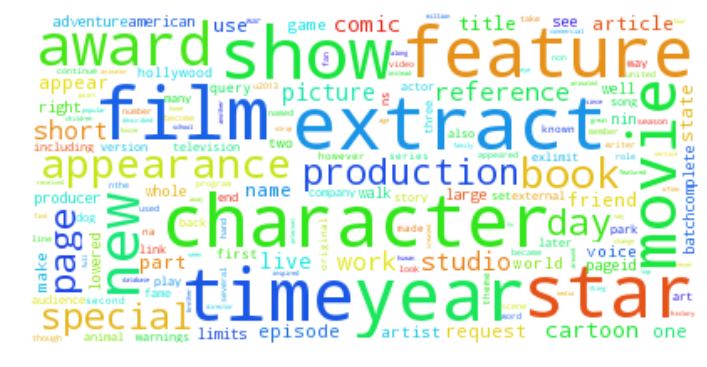

In [63]:
# Convert tokens in documents into long strings using TF-IDF scores
communityNum = 0 #This number represents what community in the partition the word cloud is for
text = ""
token_count = 0
for token in tf_idf_comms[communityNum]:
    for i in range(int(tf_idf_comms[communityNum][token])):
        text = text + " " + token
    # Print progress
    token_count += 1
    if 100.0*token_count/len(tf_idf_comms[communityNum]) % 5 < 0.001:
        print "The loop is %f percent done" % (100.0*token_count/len(tf_idf_comms[communityNum]))

# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(max_font_size=45,
                      background_color='white').generate(text)
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis("off")

pic_name = 'word_cloud_fict_' + str(communityNum+1) + '.png'
plt.savefig(pic_name)

plt.show()

The fictional characters clearly also relates to Hollywood entertainment industry. "film", "movie", "star", "show", "award", words that all can be observed in the other word clouds. You can also find "cartoon" in there, so the expectations was not totally off. The fictional characters are certainly characters that fit in the Hollywood Walk of Fame network.

Apparently it is a lot easier to detect musicians and other recording artist based on the words in a text alone. The word clouds was clear was this kind of community. It was also possible to detect words related to the Hollywood entertainment industry in the community of the best partition. It Motion pictures and possibly Broadcast television related. It was especially categories difficult to detect what communities were supposed to represent the Radio and Live performance categories (of they were created in the best partition). It seems that the Python Louvain algorithm did a better job dividing Motion picture and Audio recording stars into the right groups than the Hollywood Chamber of Commerce who decides which persons should receive stars and what category they belong to. The Award partition was generally not good, as nothing specific could be said from the text analysis.

For this project text analysis was used to find a common source for Hollywood stars and as well looking at partitions to try and explain what understanding was behind communities. The tools from text analysis used in this project is information retrievel heavily relying on TF-IDF statistics. The dataset consists of Wikipedia pages which basically information about many things put in writing, so information retrievel integrate well with the data.

## Part 4:  Discussion

The purpose of this project was to examine a dataset of the stars on the Hollywood Walk of Fame. One of the main ideas was to look for extraordinary person with star on the Walk of Fame, that would essential part of the Hollywood. A network was created of all the stars and the project went to examine and combine different centrality measures in order to say which person was the significant part of the network. This turned out to be Frank Sinatra, which intuitively makes a lot of sense he is regarded very influential person and was one of the biggest entertainers receiving awards from multiple categories. This part of the project went very since it was quite easy to conclude that Sinatra was a central part of the Hollywood star network, he was at the top of lists of nodes with highest centrality values.

Another idea was to see if any real world classification could be seen in the network using community detection. This part of the project was combined with text analysis to explain what communities was found. These sections showed mixed results. It was straight up to build partitions using features of the network and the Python Louvain algorithm to find the best partition. Some sommunities could be explained using information retrievel from text analysis, however not communities did get clearly interpreted. That being said some communities was defintely easy to relate to the Hollywood entertainment industry and it was easy to see a division of stars into some categories (not all the proposed groups though). An unexpected community was also detected in the best partition. The network apparently had a group of nodes representing the western film genre.

To improve the project one could defintely work further with information retrievel to explain the dataset. Different logarithm and tokenization techniques was explored but more could done, and this could possibly explain partition of network even better. The important theories of Network Science used in this project was node centrality and community structures as they corresponded well with ideas for the dataset. From natural language processing regular expression was extensively used to extract links from wikipages and clean the retrived information. The text analysis focused on one major task from NLP, information retrievel.